<a id='top'></a>

# Clustering to improve logerror

**1.** [**Project Plan**](#Project-Plan)<br>
**2.** [**Data Acquistion**](#shit_aint_working)<br>
**3.** [**Explore Data**](#explore_data)<br>
**4.** [**Create a Baseline Model**](#baseline_model)<br>
**5.** [**Create and Compare Different Models**](#modeling)<br>
**6.** [**Predict on Test Model**](#predict_test)<br>
**7.** [**Exporting CSV with Predictions**](#csv_export)

## 1. Project Plan

### Background

We've been tasked with using the Clustering ML Algorithm to see if we can improve on logerror estimates.

- Plan and strategize for using Clustering to tackle the problem
- Acquire and prepare zillow data
- Explore data with visuals discuss/combine findings
- Finalize how we want to handle the data
    - missing values
    - imputing
    - outliers
    - etc.
- Use clustering methodologies to find possible features to predict our target > logerror
- Try different models then decide what model we want to move forward with

### Goals

- Improve our original estimate of the log error by using clustering methodologies.
- Identify the driver of logerror
- Build a model to predict logerror

The deliverables for this project are the following data assets:

1. Report detailing our analysis in an .ipynb format
2. Detailed README on a Github and repo containing all files for this project
3. All .py files that are necessary to reproducible work

### Data Dictionary for Selected Features

#### *Target Variable*:

**logerror** - tbd


#### *Independent Variables*:

**tbd** - tbd

#### *Data Scaling*:

**tbd** - tbd

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# general
import pandas as pd
import numpy as np

# explore/ stat
import scipy.stats as stats

# visuals
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D

# support modules
import acquire
import wrangle
import prepare
import split_scale
import cluster
import model

# look at function for summarize plot
# import summarize
# import prepare
# import explore
# import split_scale

# modeling
from sklearn.cluster import KMeans, dbscan
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from math import sqrt
from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

# view full DF
pd.set_option('display.max_columns', None)

<a id='shit_aint_working'></a>

# Data Acquistion

Retrieve from the Codeup Zillow_db:

- Latest transactions occured within the year of 2017 for each property
- Logerror
- All fields related to each properties
- Gather descriptions by joining description tables
- Only properties where latitude and longitude are not null
- Only single family homes (SFR)

In [2]:
df = acquire.get_zillow_data()

In [3]:
df.head()

,parcelid,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,yearbuilt,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,logerror,transactiondate
0,14297519,3.5,4.0,3100.0,6059.0,33634931.0,-117869207.0,4506.0,1998.0,485713.0,1023282.0,537569.0,11013.72,0.025595,2017-01-01
1,17052889,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,1967.0,88000.0,464000.0,376000.0,5672.48,0.055619,2017-01-01
2,14186244,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,1962.0,85289.0,564778.0,479489.0,6488.30,0.005383,2017-01-01
3,12177905,3.0,4.0,2376.0,6037.0,34245180.0,-118240722.0,13038.0,1970.0,108918.0,145143.0,36225.0,1777.51,-0.103410,2017-01-01
4,10887214,3.0,3.0,1312.0,6037.0,34185120.0,-118414640.0,278581.0,1964.0,73681.0,119407.0,45726.0,1533.89,0.006940,2017-01-01


In [4]:
df.shape

(76725, 15)

In [5]:
df.isnull().sum()

parcelid                           0
bathroomcnt                        0
bedroomcnt                         0
calculatedfinishedsquarefeet      11
fips                               0
latitude                           0
longitude                          0
lotsizesquarefeet               8152
yearbuilt                         65
structuretaxvaluedollarcnt        87
taxvaluedollarcnt                  1
landtaxvaluedollarcnt              1
taxamount                          5
logerror                           0
transactiondate                    0
dtype: int64

In [6]:
df = wrangle.handle_nulls(df)

In [7]:
df.isnull().sum()

parcelid                        0
bathroomcnt                     0
bedroomcnt                      0
calculatedfinishedsquarefeet    0
fips                            0
latitude                        0
longitude                       0
lotsizesquarefeet               0
yearbuilt                       0
structuretaxvaluedollarcnt      0
taxvaluedollarcnt               0
landtaxvaluedollarcnt           0
taxamount                       0
logerror                        0
transactiondate                 0
dtype: int64

In [8]:
df = wrangle.prepare_zillow(df)

Derive Features

In [9]:
df = prepare.transaction_month(df)

In [10]:
df = prepare.tax_rate(df)

In [11]:
#df.hist(figsize=(36, 20))
#plt.show()

In [12]:
# remove outlier
col_out = ["bathroomcnt", "bedroomcnt", "tax_rate", "calculatedfinishedsquarefeet", "lotsizesquarefeet", "structuretaxvaluedollarcnt", "taxvaluedollarcnt", "landtaxvaluedollarcnt"]

In [13]:
df = prepare.remove_outliers_iqr(df, col_out)

In [14]:
# Additional outlier removal
df = df[((df.bathroomcnt <= 7) & (df.bedroomcnt <= 7) & 
         (df.bathroomcnt > 0) & 
         (df.bedroomcnt > 0) & 
         (df.calculatedfinishedsquarefeet < 7000) & 
         (df.tax_rate < .05)
        )]

In [15]:
df = prepare.bed_bath_ratio(df)

In [16]:
df = prepare.better_names(df)

In [17]:
df.shape

(59930, 17)

In [18]:
# parcelDensity30000 = get_pde(df,30000)
# parcelDensity10000 = get_pde(df,10000)
# parcelDensity3000 = get_pde(df,3000)
# parcelDensity1000 = get_pde(df,1000)
# parcelDensity300 = get_pde(df,300)

In [19]:
# plt.figure(figsize=(14,14))
# plt.axis("off")
# plt.title("Nightclub Plot")
# plt.scatter(df['longitude'].values, df['latitude'].values, c=parcelDensity30000,cmap='inferno', s=1, edgecolor='')

In [20]:
# from scipy.stats import rankdata
# rankScaled30000 = 100*rankdata(parcelDensity30000)/len(parcelDensity30000)
# rankScaled10000 = 100*rankdata(parcelDensity10000)/len(parcelDensity10000)
# rankScaled3000 = 100*rankdata(parcelDensity3000)/len(parcelDensity3000)
# rankScaled1000 = 100*rankdata(parcelDensity1000)/len(parcelDensity1000)
# rankScaled300 = 100*rankdata(parcelDensity300)/len(parcelDensity300)

In [21]:
# fig = plt.figure(figsize=(15,15))

# ax1 = fig.add_subplot(221)
# ax1.set_title('bandwidth = 10,000')
# ax1.set_axis_off()
# ax1.scatter(df['longitude'].values, df['latitude'].values, c=rankScaled10000,cmap='inferno', s=1, edgecolor='')

# ax2 = fig.add_subplot(222)
# ax2.set_title('bandwidth = 3,000')
# ax2.set_axis_off()
# ax2.scatter(df['longitude'].values, df['latitude'].values, c=rankScaled3000,cmap='inferno', s=1, edgecolor='')

# ax3 = fig.add_subplot(223)
# ax3.set_title('bandwidth = 1,000')
# ax3.set_axis_off()
# ax3.scatter(df['longitude'].values, df['latitude'].values, c=rankScaled1000,cmap='inferno', s=1, edgecolor='')

# ax4 = fig.add_subplot(224)
# ax4.set_title('bandwidth = 300')
# ax4.set_axis_off()
# ax4.scatter(df['longitude'].values, df['latitude'].values, c=rankScaled300,cmap='inferno', s=1, edgecolor='')

In [22]:
train, test = split_scale.train_test(df)

In [23]:
print('train:', train.shape)
print('test:', test.shape)

train: (41951, 17)
test: (17979, 17)


In [24]:
train.head()

,longitude,latitude,age,month,bedroomcnt,bathroomcnt,square_footage,lot_size,house_value,land_value,full_value,tax_rate,Los_Angeles,Orange,Ventura,logerror,bed_bath_ratio
44758,-118476118.0,34061074.0,78.0,6,3.0,2.0,2898.0,7070.0,375122.0,244299.0,619421.0,0.013315,1,0,0,1.775059,1.5
76378,-117984001.0,34019979.0,61.0,9,4.0,2.0,1937.0,6048.0,179233.0,218384.0,397617.0,0.011867,1,0,0,-0.116786,2.0
3539,-118461331.0,33974843.0,48.0,1,4.0,5.0,3199.0,2884.0,309266.0,924804.0,1234070.0,0.012103,1,0,0,0.008819,0.8
35048,-117922000.0,33854800.0,54.0,5,2.0,2.0,1157.0,7201.0,81120.0,193295.0,274415.0,0.012080,0,1,0,-0.017483,1.0
31603,-117687326.0,33522157.0,31.0,5,3.0,3.0,1555.0,8600.0,167386.0,327332.0,494718.0,0.010014,0,1,0,0.006042,1.0


In [25]:
scaler, train_scaled, test_scaled = split_scale.min_max_scaler(train, test)

#### [Got back to the top](#top)

# Explore

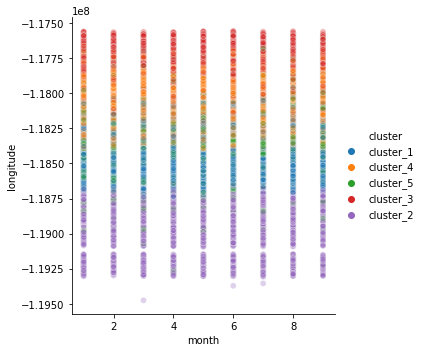

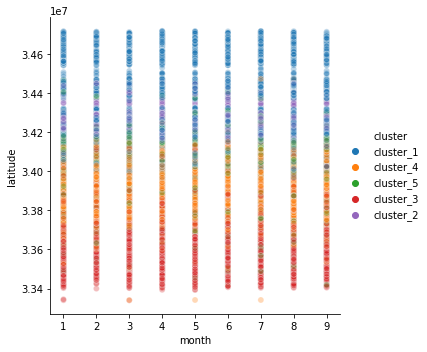

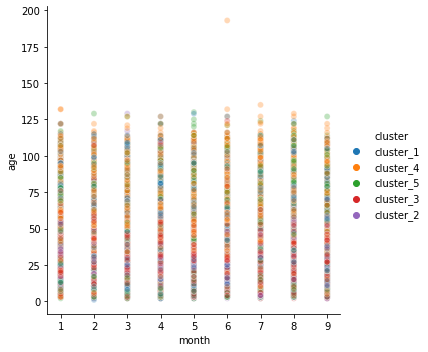

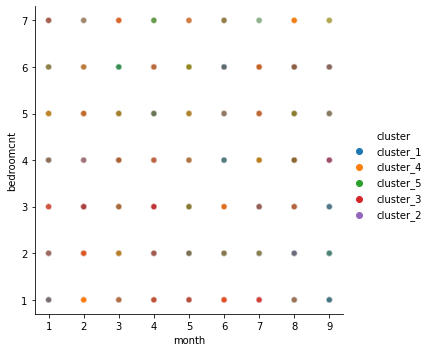

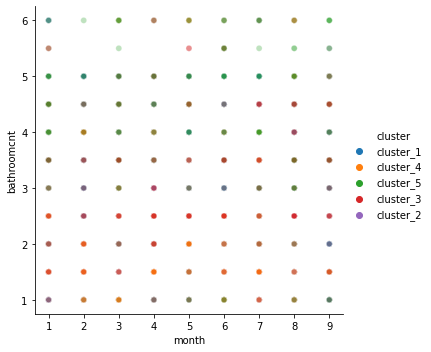

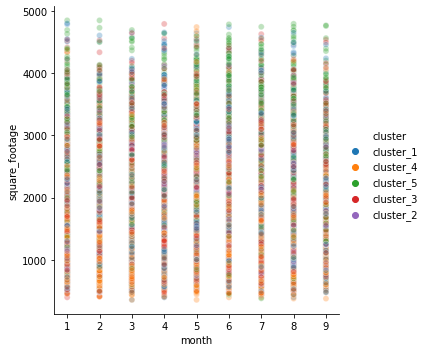

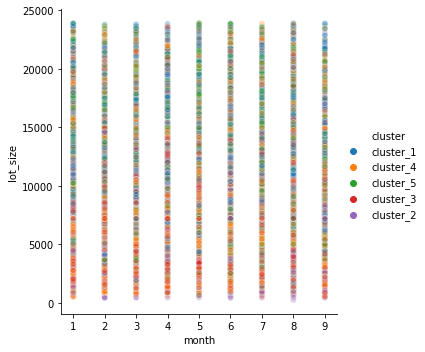

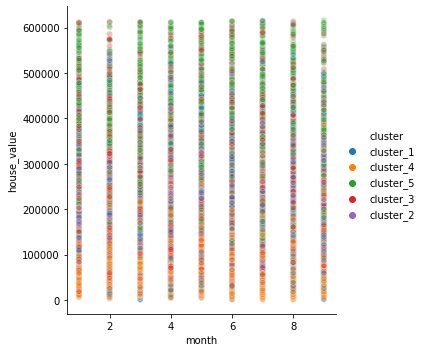

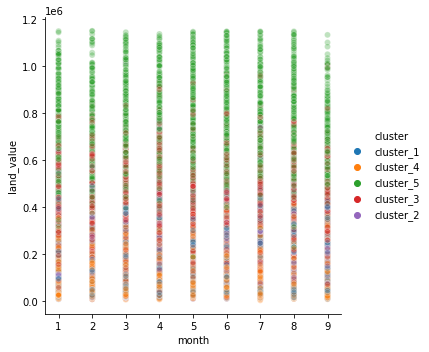

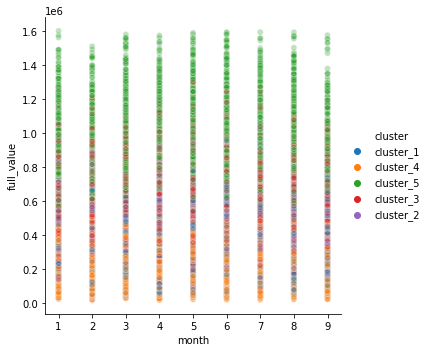

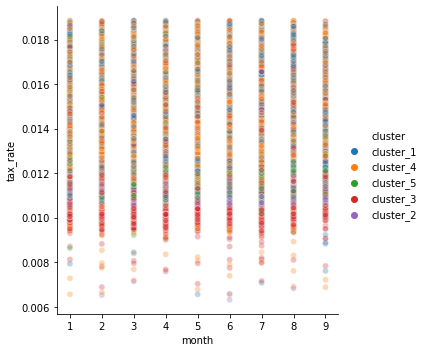

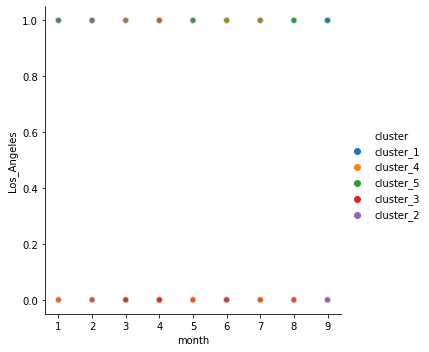

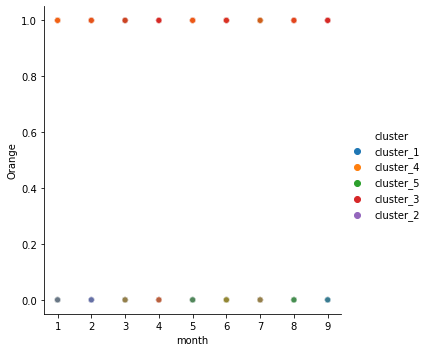

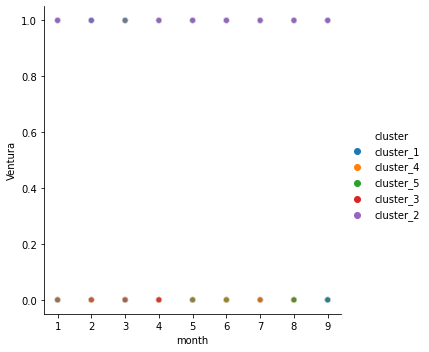

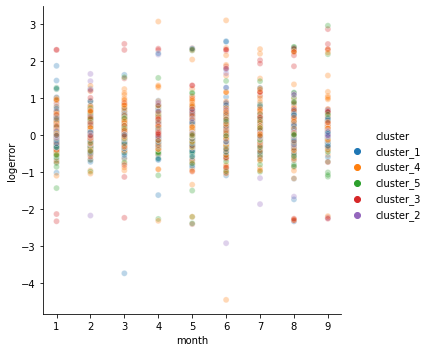

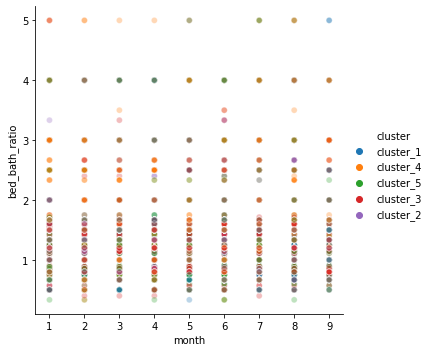

In [26]:
cluster.k_cluster_all(train, "month", 5)

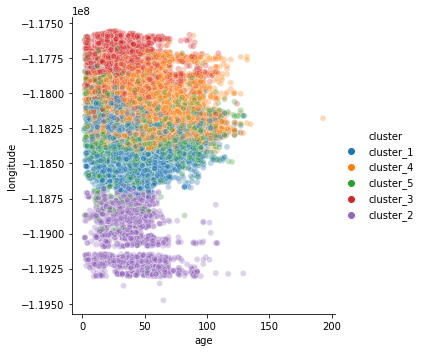

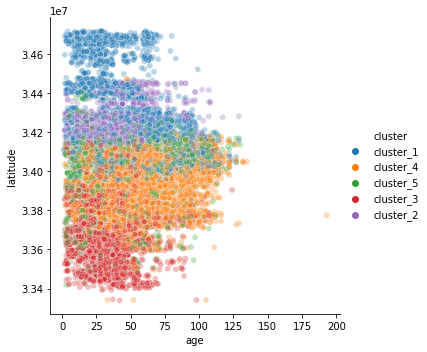

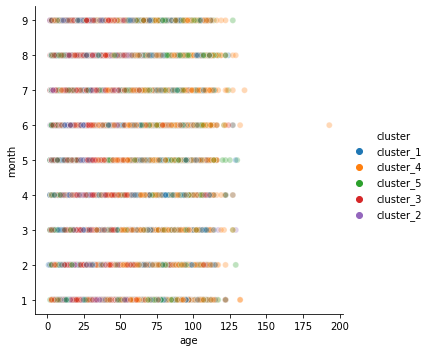

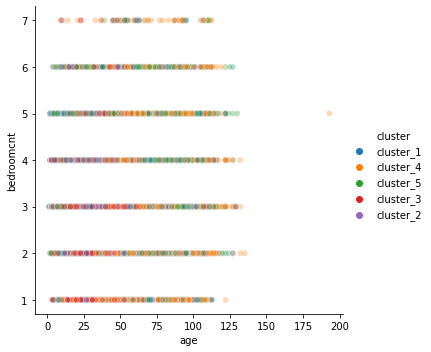

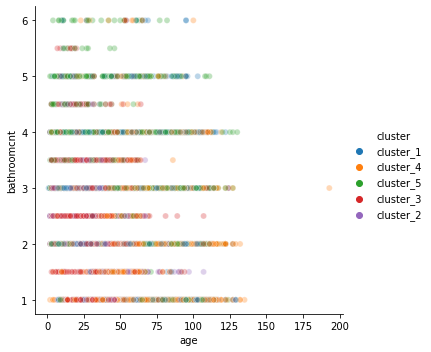

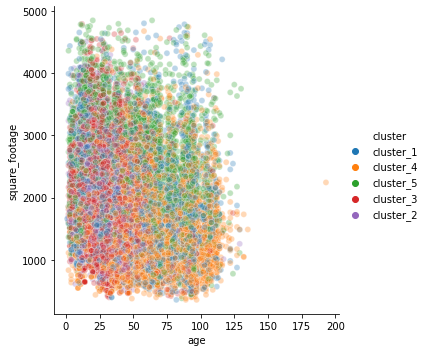

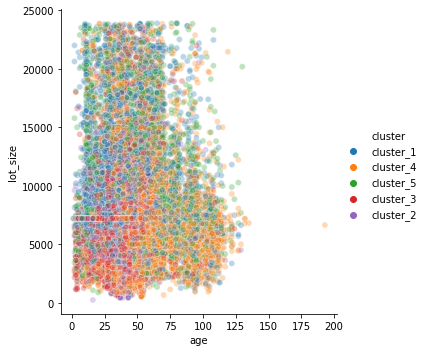

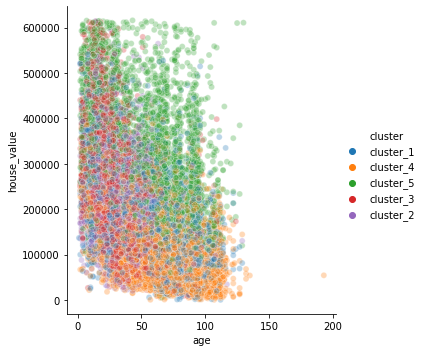

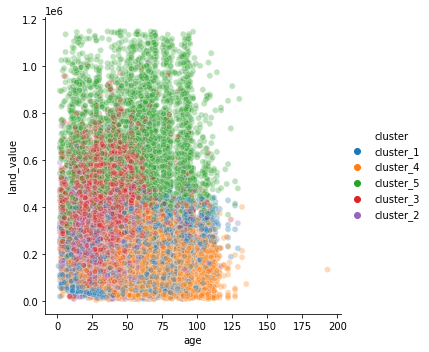

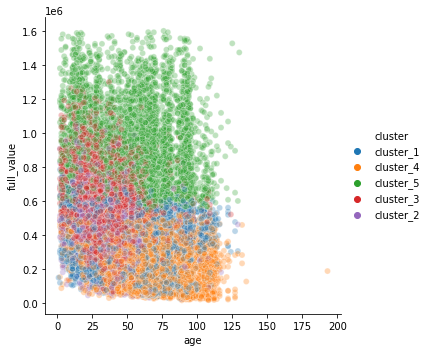

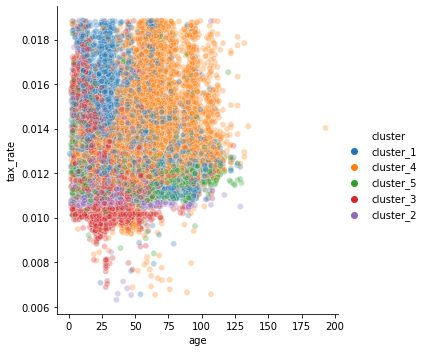

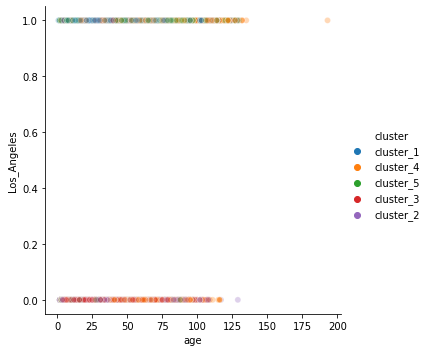

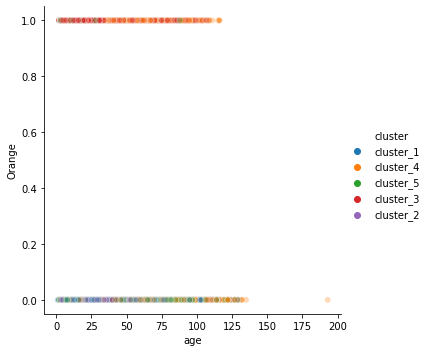

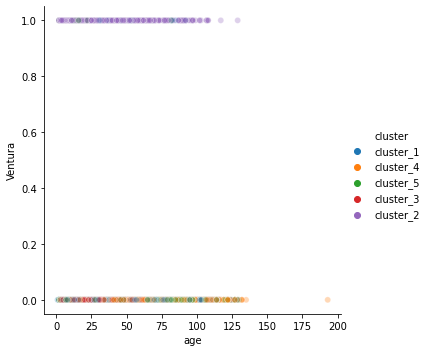

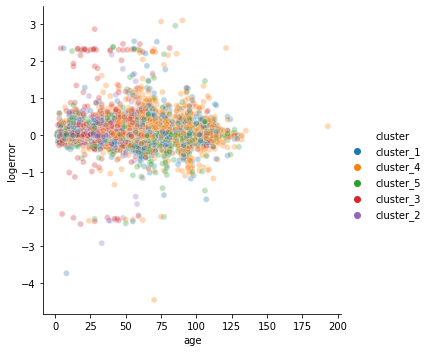

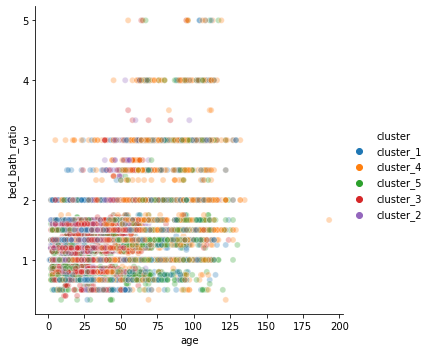

In [27]:
cluster.k_cluster_all(train, "age", 5)

    k           sse
0   1  8.650905e+15
1   2  3.793719e+15
2   3  2.466915e+15
3   4  1.774571e+15
4   5  1.350070e+15
5   6  1.020409e+15
6   7  8.261381e+14
7   8  6.691515e+14
8   9  5.820371e+14
9  10  4.943076e+14


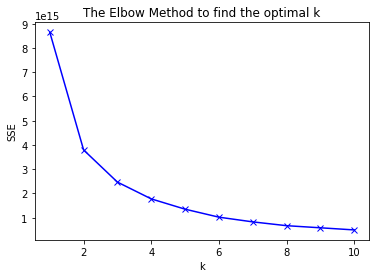

In [28]:
#cluster.elbow(train[["latitude","longitude"]], 10)

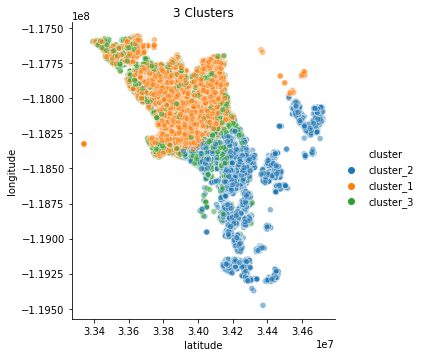

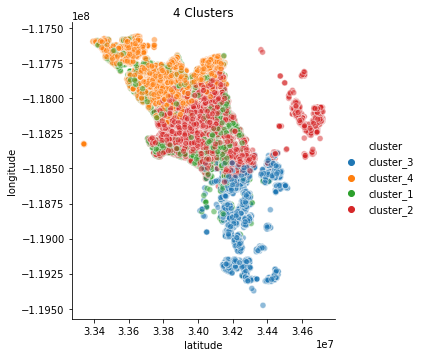

In [29]:
cluster.k_cluster_2d(train, "latitude", "longitude", 4, 3)

Target Exploration

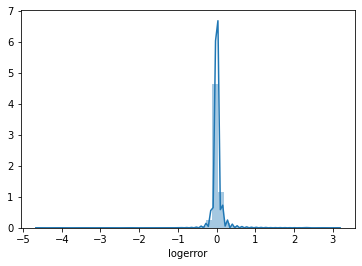

In [73]:
# overall logerror distribution 
sns.distplot(df.logerror)

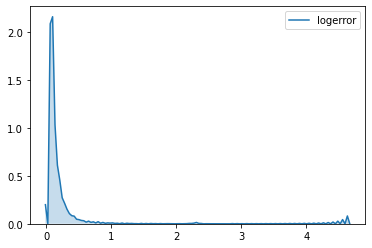

In [31]:
# absolute value of logerror
sns.kdeplot(df.logerror.abs(), shade=True)
plt.show()

Correlation between Features/ Target

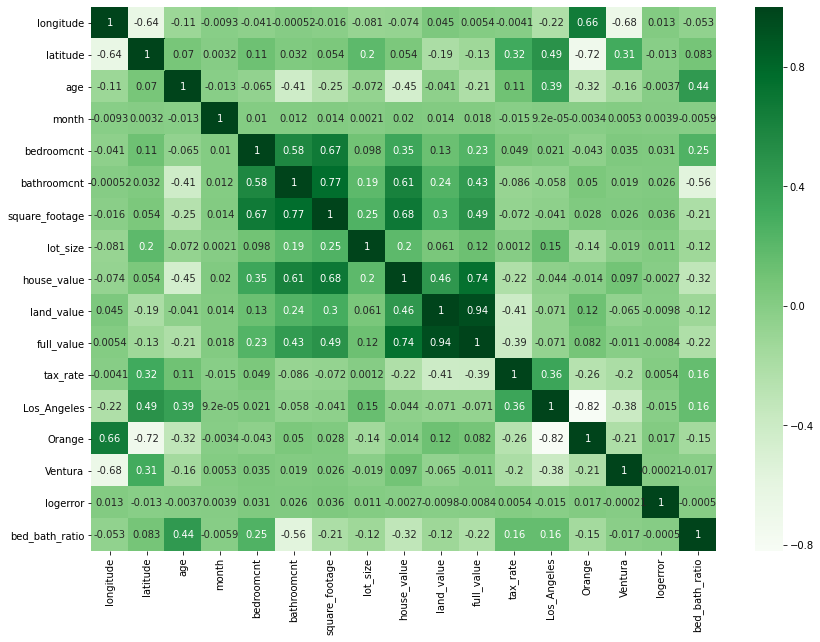

In [32]:
# Overall correlation of the features and the target.
plt.figure(figsize=(14, 10))
sns.heatmap(df.corr(), cmap='Greens', annot=True)

<function matplotlib.pyplot.show(*args, **kw)>

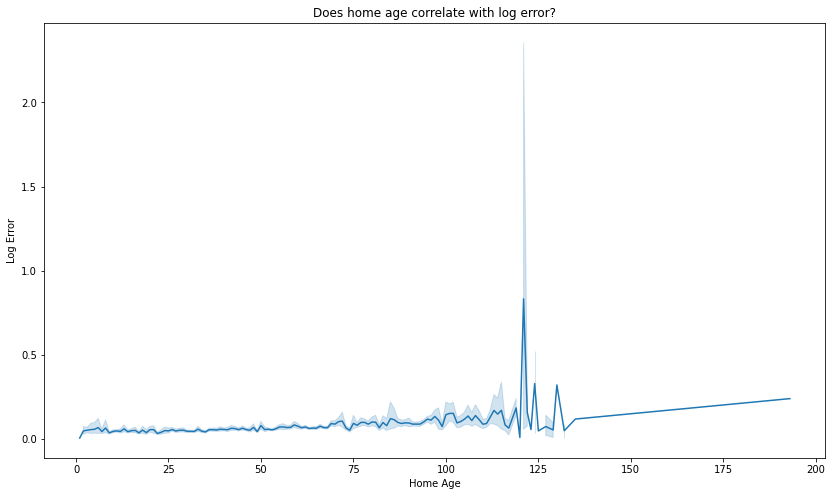

In [33]:
plt.figure(figsize=(14,8))
sns.lineplot(x = train.age, y = train.logerror.abs())
plt.xlabel('Home Age')
plt.ylabel('Log Error')
plt.title('Does home age correlate with log error?')
plt.show

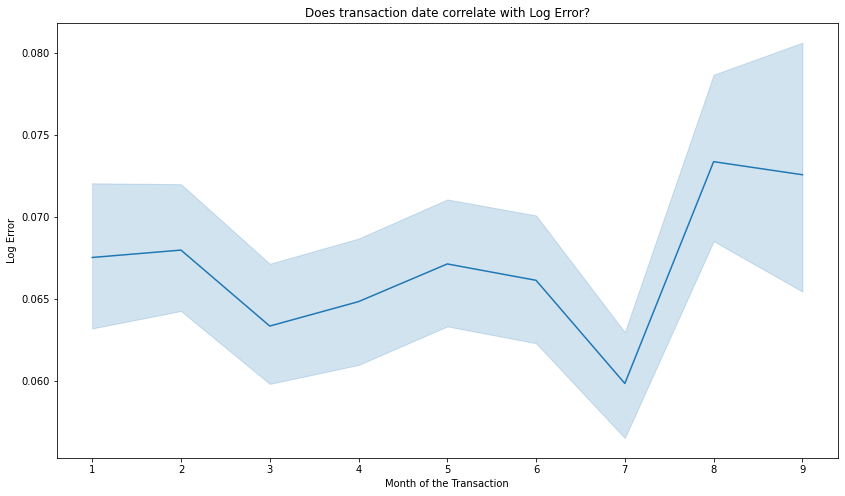

In [34]:
plt.figure(figsize=(14,8))
sns.lineplot(train.month, train.logerror.abs())
plt.xlabel('Month of the Transaction')
plt.ylabel('Log Error')
plt.title('Does transaction date correlate with Log Error?')
plt.show()

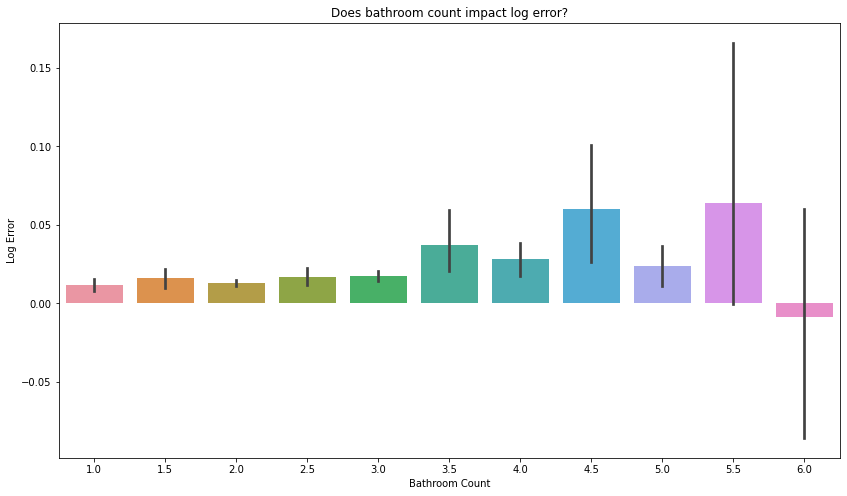

In [35]:
plt.figure(figsize=(14,8))
with sns.color_palette('Blues'):
    sns.barplot(x='bathroomcnt', y='logerror', data=train)
plt.xlabel('Bathroom Count')
plt.ylabel('Log Error')
plt.title('Does bathroom count impact log error?')
plt.show()

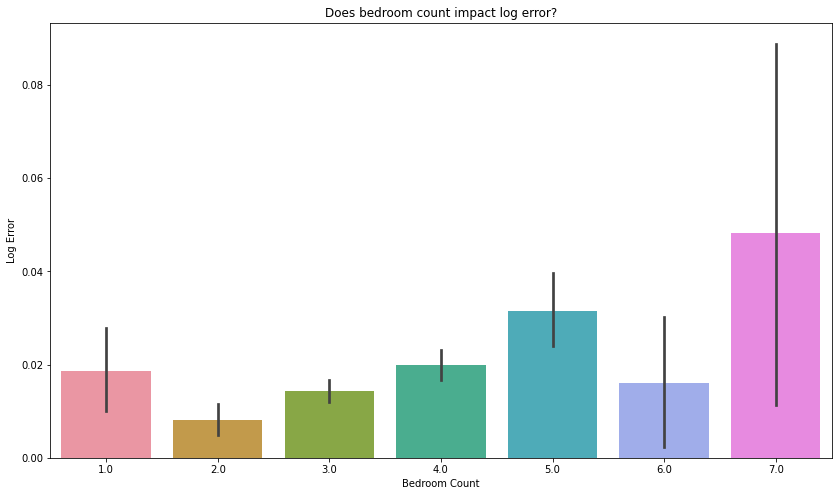

In [36]:
plt.figure(figsize=(14,8))
with sns.color_palette("Blues"):
    sns.barplot(x='bedroomcnt', y='logerror', data=train)
plt.xlabel('Bedroom Count')
plt.ylabel('Log Error')
plt.title('Does bedroom count impact log error?')
plt.show()

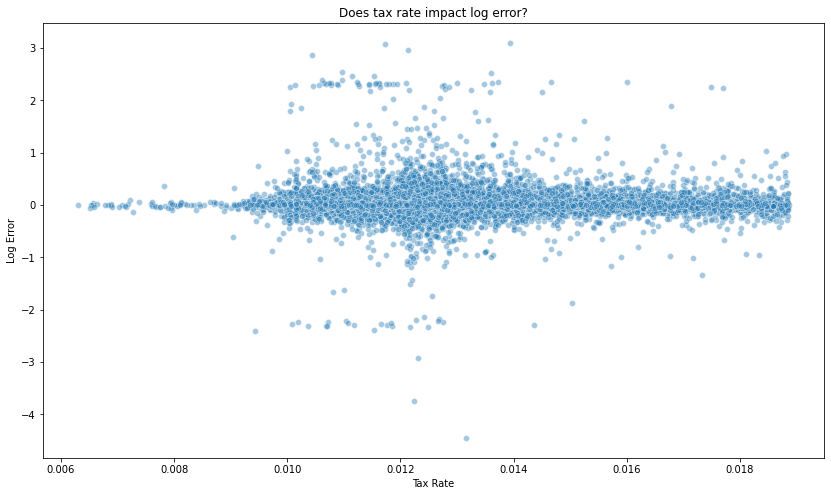

In [37]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='tax_rate', y='logerror', data=train, alpha=.4)
plt.xlabel('Tax Rate')
plt.ylabel('Log Error')
plt.title('Does tax rate impact log error?')
plt.show()

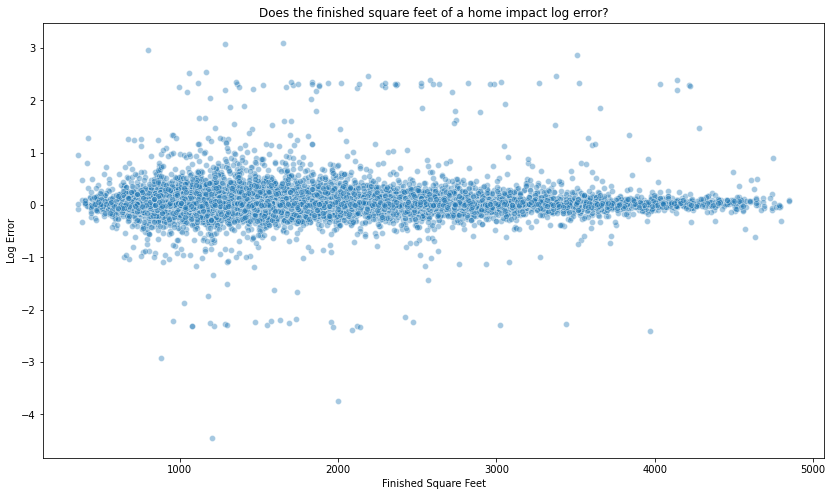

In [38]:
plt.figure(figsize=(14,8))
sns.scatterplot(x='square_footage', y='logerror', data=train, alpha=.4)
plt.xlabel('Finished Square Feet')
plt.ylabel('Log Error')
plt.title('Does the finished square feet of a home impact log error?')
plt.show()

In [39]:
# parcelDensity30000 = cluster.get_pde(df,30000)

# plt.figure(figsize=(14,14))
# plt.axis("off")
# plt.title("Parcel Density Estimation")
# plt.scatter(df['longitude'].values, df['latitude'].values, c=parcelDensity30000,cmap='inferno', s=1, edgecolor='')
# plt.show()

Feature Engineering

In [61]:
train_size_age = train_scaled[["square_footage","lot_size","age"]]
test_size_age = test_scaled[["square_footage","lot_size","age"]]

train_location_tax = train_scaled[["latitude","longitude","tax_rate"]]
test_location_tax = test_scaled[["latitude","longitude","tax_rate"]]

train_location_size = train_scaled[["latitude","longitude","square_footage", "lot_size"]]
test_location_size = test_scaled[["latitude","longitude", "square_footage", "lot_size"]]

train_month_val_bed = train_scaled[["month", "house_value","bathroomcnt"]]
test_month_val_bed = test_scaled[["month", "house_value", "bathroomcnt"]]

train_month_val_ratio = train_scaled[["month", "age","bedroomcnt"]]
test_month_val_ratio = test_scaled[["month", "age","bedroomcnt"]]

In [57]:
train_scaled.columns

Index(['longitude', 'latitude', 'age', 'month', 'bedroomcnt', 'bathroomcnt',
       'square_footage', 'lot_size', 'house_value', 'land_value', 'full_value',
       'tax_rate', 'Los_Angeles', 'Orange', 'Ventura', 'logerror',
       'bed_bath_ratio', 'cluster_sf_a_ls', 'cluster_loc_tax',
       'cluster_loc_size', 'cluster_month_val_bed', 'cluster_month_val_ratio'],
      dtype='object')

In [41]:
#cluster.elbow(train_size_age)

In [42]:
#cluster.k_cluster_3d(train_size_age,"square_footage","age","lot_size", 5)

In [43]:
#cluster.elbow(train_location_tax)

In [44]:
#cluster.k_cluster_3d(train_location_tax,"latitude","longitude","tax_rate", 5)

In [45]:
#cluster.elbow(train_location_size)

Create cluster values from the seen clusters above

In [46]:
#cluster.elbow(train_month_val_bed)

In [47]:
#cluster.elbow(train_month_val_ratio)

In [62]:
# def kmeans_model(df,n):
#     kmeans = KMeans(n_clusters=n, random_state=123)
#     kmeans.fit(df)
#     return kmeans.labels_

train_scaled["cluster_sf_a_ls"] = model.kmeans_model(train_size_age, 5)
train_scaled["cluster_loc_tax"] = model.kmeans_model(train_location_tax, 5)
train_scaled["cluster_loc_size"] = model.kmeans_model(train_location_size, 5)
train_scaled["cluster_month_val_bed"] = model.kmeans_model(train_month_val_bed, 5)
train_scaled["cluster_month_val_ratio"] = model.kmeans_model(train_month_val_ratio, 5)

test_scaled["cluster_sf_a_ls"] = model.kmeans_model(test_size_age, 5)
test_scaled["cluster_loc_tax"] = model.kmeans_model(test_location_tax, 5)
test_scaled["cluster_loc_size"] = model.kmeans_model(test_location_size, 5)
test_scaled["cluster_month_val_bed"] = model.kmeans_model(test_month_val_bed, 5)


In [49]:
def test_sig(cluster_column,df):
    """
    Takes a column of clusters and performs a t-test with the logerrors of cluster (subset) against the population logerror.
    """  
    ttest_list = []
    pval_list = []
    stat_sig = []

    for cluster in cluster_column.unique():
        ttest, pval = stats.ttest_1samp(df["logerror"][cluster_column == cluster],df["logerror"].mean(),axis=0,nan_policy="propagate")
        ttest_list.append(ttest)
        pval_list.append(pval)
        sig = pval < 0.05
        stat_sig.append(sig)
        
    stats_cluster_column = pd.DataFrame({"ttest":ttest_list,"pval":pval_list,"stat_sig":stat_sig})
    return stats_cluster_column

In [50]:
test_sig(train_scaled.cluster_sf_a_ls, train_scaled)

,ttest,pval,stat_sig
0,0.260565,0.794435,False
1,3.419595,0.000632,True
2,-0.469816,0.638494,False
3,-3.724870,0.000196,True
4,1.682864,0.092500,False


In [51]:
test_sig(train_scaled.cluster_loc_tax, train_scaled)

,ttest,pval,stat_sig
0,-1.720276,0.085401,False
1,1.571548,0.116085,False
2,2.044161,0.040996,True
3,-0.012093,0.990352,False
4,-2.692951,0.007132,True


In [52]:
test_sig(train_scaled.cluster_loc_size, train_scaled)

,ttest,pval,stat_sig
0,4.575684,0.000005,True
1,-2.733806,0.006268,True
2,-0.062851,0.949886,False
3,1.117630,0.263807,False
4,-1.987081,0.046941,True


In [53]:
test_sig(train_scaled.cluster_month_val_bed, train_scaled)

,ttest,pval,stat_sig
0,3.161519,0.001577,True
1,-0.118059,0.906023,False
2,-1.016550,0.309419,False
3,-2.671990,0.007550,True
4,1.113367,0.265581,False


In [63]:
test_sig(train_scaled.cluster_month_val_ratio, train_scaled)

,ttest,pval,stat_sig
0,-3.527140,0.000422,True
1,4.065378,0.000049,True
2,1.446578,0.148075,False
3,-0.243786,0.807402,False
4,-0.415993,0.677426,False


In [55]:
train_scaled.cluster_month_val_ratio.value_counts()

0    13299
3    10784
2     9634
1     4688
4     3546
Name: cluster_month_val_ratio, dtype: int64

In [56]:
train_scaled.cluster_month_val_bed.value_counts()

4    12338
2    10163
1     8744
0     5964
3     4742
Name: cluster_month_val_bed, dtype: int64

In [65]:
train.logerror.value_counts()

 0.000420    5
 0.000375    4
 0.002139    4
 0.006909    4
 0.000231    4
            ..
 0.044840    1
 0.025241    1
 0.006015    1
-0.022406    1
 0.059290    1
Name: logerror, Length: 41768, dtype: int64

Modeling

Splitting out X and Y

In [93]:
X_train = train_scaled[['lot_size','age','full_value','longitude','latitude','square_footage']]
y_train = train_scaled[['logerror']]

X_test = test_scaled[['lot_size','age','full_value','longitude','latitude','square_footage']]
y_test = test_scaled[['logerror']]

In [100]:
predictions = y_train[['logerror']]
predictions = predictions.rename(columns={'logerror': 'actual'})
predictions.head()

,actual
44758,0.824503
76378,0.574090
3539,0.590715
35048,0.587234
31603,0.590348


First our baseline

In [110]:
# create baseline
X_train = train_scaled[['lot_size','age','full_value','longitude','latitude','square_footage']]
y_train = train_scaled[['logerror']]

y_train['mean_logerror'] = y_train.logerror.mean()
rmse_baseline = np.sqrt(mean_squared_error(y_train.logerror, y_train.mean_logerror))
r2_baseline = r2_score(y_train.logerror, y_train.mean_logerror)

predictions['rsme_baseline'] = ('{:.4f}'.format(rmse_baseline))
print('This is the baseline dataset model performance')
print(f'RSME = {rmse_baseline:.4f}')
print(f'R2 score =  {r2_baseline:.4f}')

This is the baseline dataset model performance
RSME = 0.0216
R2 score =  0.0000


In [117]:
# create decision tree regressor
X_train = train_scaled[['lot_size','age','full_value','longitude','latitude','square_footage']]
y_train = train_scaled[['logerror']]

regressor = DecisionTreeRegressor(max_depth = 8, random_state=121)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_train)

rmse_dt_train = np.sqrt(mean_squared_error(y_train, y_pred))
r2_dt_train = r2_score(y_train, y_train_predicted)

predictions['rsme_dt'] = ('{:.4f}'.format(rmse_dt_train))
print('This is the train dataset model performance')
print(f'RSME = {rmse_dt_train:.4f}')
print(f'R2 score =  {r2_dt_train:.4f}')

This is the train dataset model performance
RSME = 0.0211
R2 score =  0.0544


In [122]:
predictions.head()

,actual,rsme_baseline,rsme_dt,rsme_rf
44758,0.824503,0.0216,0.0211,0.0216
76378,0.574090,0.0216,0.0211,0.0216
3539,0.590715,0.0216,0.0211,0.0216
35048,0.587234,0.0216,0.0211,0.0216
31603,0.590348,0.0216,0.0211,0.0216


In [121]:
# create random forest regressor
X_train = train_scaled[['lot_size','age','full_value','longitude','latitude','square_footage']]
y_train = train_scaled[['logerror']]

regressor = RandomForestRegressor(max_depth = 2, random_state=121, n_estimators=100)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_train)

rmse_rf_train = np.sqrt(mean_squared_error(y_train, y_pred))
r2_rf_train = r2_score(y_train, y_pred)

predictions['rsme_rf'] = ('{:.4f}'.format(rmse_rf_train))
print('This is the train dataset model performance')
print(f'RSME = {rmse_rf_train:.4f}')
print(f'R2 score =  {r2_rf_train:.4f}')

This is the train dataset model performance
RSME = 0.0216
R2 score =  0.0056


#### [Got back to the top](#top)